In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
import matplotlib.pyplot as plt
from skimage import io
import cv2 as cv

C:\Users\joeag\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# 5 images per individual dataset
class FacesDataset5(Dataset):
    def __init__(self,root_dir,transform=None):
        self.root_dir=root_dir
        self.transform =transform
    def __len__(self):
        return 5*33333
    def __getitem__(self, i):
        directory1=str(self.root_dir)+'/'+str((i//5)+100000)+'/'+str(i%5)+'.png'
        j=torch.randint(5,(1,)).item()
        while j == i%5:
            j=torch.randint(5,(1,)).item()
        directory2=str(self.root_dir)+'/'+str((i//5)+100000)+'/'+str(j)+'.png'
        k=torch.randint(len(self),(1,)).item()
        directory3=str(self.root_dir)+'/'+str((k//5)+100000)+'/'+str(k%5)+'.png'

        image1 = cv.cvtColor(cv.imread(directory1, 3), cv.COLOR_BGR2GRAY)
        image2 = cv.cvtColor(cv.imread(directory2, 3), cv.COLOR_BGR2GRAY)
        image3 = cv.cvtColor(cv.imread(directory3, 3), cv.COLOR_BGR2GRAY)
        if self.transform:
            image1 = self.transform(image1)
            image2 = self.transform(image2)
            image3 = self.transform(image3)
            
        return(image1, image2, image3)
    
# 72 images per individual dataset
class FacesDataset72(Dataset):
    def __init__(self,root_dir,transform=None):
        self.root_dir=root_dir
        self.transform =transform
    def __len__(self):
        return 72*2000
    def __getitem__(self, i):
        
        # Get ith headshot
        directory1=str(self.root_dir)+'/'+str(i//72)+'/'+str(i%5)+'.png'
        j=torch.randint(72,(1,)).item()
        while j == i%72:
            j=torch.randint(72,(1,)).item()
            
        # Get random different pic of same individual
        directory2=str(self.root_dir)+'/'+str(i//72)+'/'+str(j)+'.png'
        
        # Get Random headshot of different individual
        k=torch.randint(len(self),(1,)).item()
        while k//72 == i//72:
            k = torch.randint(len(self), (1,)).item()
        directory3=str(self.root_dir)+'/'+str(k//72)+'/'+str(k%72)+'.png'

        image1 = cv.cvtColor(cv.imread(directory1, 3), cv.COLOR_BGR2GRAY)
        image2 = cv.cvtColor(cv.imread(directory2, 3), cv.COLOR_BGR2GRAY)
        image3 = cv.cvtColor(cv.imread(directory3, 3), cv.COLOR_BGR2GRAY)
        if self.transform:
            image1 = self.transform(image1)
            image2 = self.transform(image2)
            image3 = self.transform(image3)
            
        return(image1, image2, image3)

In [7]:
direc = "data5"
train_dataset = FacesDataset5(direc, transform=transforms.ToTensor())

In [3]:
class Encoder(nn.Module):
    def __init__(self, channels_img, features, img_size):
        super(Encoder, self).__init__()
        self.img_size = img_size
        
        self.encoder = nn.Sequential(
            
            nn.Conv2d(channels_img, features*8, (4,4), (2,2), 1),
            nn.BatchNorm2d(features*8),
            nn.ReLU(),
            
            self._enc_block(features*8, features*16, (4,4), (2,2), 1),
            self._enc_block(features*16, features*16, (4,4), (2,2), 1),
            self._enc_block(features*16, features*32, (4,4), (2,2), 2),
            self._enc_block(features*32, features*16, (4,4), (2,2), 1), #256x4x4

            nn.Flatten(),
            nn.Linear(features*16*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 128),
            nn.Softmax(dim=1), #Normalise
            
        )
           
    
    def _enc_block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU6(),
            nn.Dropout(0.1),
        )

    def forward(self, images):
        return self.encoder(images)

In [4]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.2)
            
def test():
    img_size = 112
    N, channels, H, W = 8, 3, img_size, img_size
    features = 16
    enc = Encoder(channels, features, img_size, )
    x = torch.randn((N, channels, H, W))
    embedded = enc(x)
    assert embedded.shape == (N, 128)
    
test()

In [5]:
LEARNING_RATE = 3e-4 # Karpathy Constant
BATCH_SIZE = 512
IMG_SIZE = 112
CHANNELS = 1
FEATURES = 16

print("initialised constants")

initialised constants


In [6]:
enc = Encoder(CHANNELS, FEATURES, IMG_SIZE).to(device)
initialize_weights(enc)
opt = optim.Adam(enc.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
summary(enc, (1, 112, 112))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 56, 56]           2,176
       BatchNorm2d-2          [-1, 128, 56, 56]             256
              ReLU-3          [-1, 128, 56, 56]               0
            Conv2d-4          [-1, 256, 28, 28]         524,288
       BatchNorm2d-5          [-1, 256, 28, 28]             512
             ReLU6-6          [-1, 256, 28, 28]               0
           Dropout-7          [-1, 256, 28, 28]               0
            Conv2d-8          [-1, 256, 14, 14]       1,048,576
       BatchNorm2d-9          [-1, 256, 14, 14]             512
            ReLU6-10          [-1, 256, 14, 14]               0
          Dropout-11          [-1, 256, 14, 14]               0
           Conv2d-12            [-1, 512, 8, 8]       2,097,152
      BatchNorm2d-13            [-1, 512, 8, 8]           1,024
            ReLU6-14            [-1, 51

In [15]:
train_loader = DataLoader(
    train_dataset,
    batch_size = BATCH_SIZE,
    shuffle=True,
)

In [7]:
enc.load_state_dict(torch.load("softmax_sd.pth"))

<All keys matched successfully>

In [17]:
NUM_EPOCHS = 10
for epoch in range(NUM_EPOCHS):
    
    for batch_idx, (im1, im2, im3) in enumerate(train_loader):

        im1 = im1.to(device) # OG
        im2 = im2.to(device) # OG again
        im3 = im3.to(device) # random bloke

        embs_1 = enc(im1)
        embs_2 = enc(im2)
        embs_3 = enc(im3)

        same_loss = (embs_1-embs_2).abs().mean()
        diff_loss = -(embs_1-embs_3).abs().mean()
        loss = same_loss + diff_loss

        enc.zero_grad()
        loss.backward()
        opt.step()
        if batch_idx %25 == 0:
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(train_loader)}  same_loss: {same_loss:.4f}  diff_loss: {diff_loss:.4f} delta: {loss.abs():.4f} delta_ratio: {(loss.abs()/same_loss):.4f}"
            )

Epoch [0/10] Batch 0/326  same_loss: 0.0046  diff_loss: -0.0085 delta: 0.0040 delta_ratio: 0.8649
Epoch [0/10] Batch 25/326  same_loss: 0.0042  diff_loss: -0.0085 delta: 0.0043 delta_ratio: 1.0178
Epoch [0/10] Batch 50/326  same_loss: 0.0045  diff_loss: -0.0100 delta: 0.0055 delta_ratio: 1.2293
Epoch [0/10] Batch 75/326  same_loss: 0.0047  diff_loss: -0.0100 delta: 0.0053 delta_ratio: 1.1412
Epoch [0/10] Batch 100/326  same_loss: 0.0040  diff_loss: -0.0103 delta: 0.0064 delta_ratio: 1.5953
Epoch [0/10] Batch 125/326  same_loss: 0.0044  diff_loss: -0.0105 delta: 0.0061 delta_ratio: 1.4065
Epoch [0/10] Batch 150/326  same_loss: 0.0038  diff_loss: -0.0105 delta: 0.0067 delta_ratio: 1.7769
Epoch [0/10] Batch 175/326  same_loss: 0.0039  diff_loss: -0.0105 delta: 0.0066 delta_ratio: 1.6873
Epoch [0/10] Batch 200/326  same_loss: 0.0039  diff_loss: -0.0104 delta: 0.0064 delta_ratio: 1.6268
Epoch [0/10] Batch 225/326  same_loss: 0.0040  diff_loss: -0.0102 delta: 0.0062 delta_ratio: 1.5561
Epoch

KeyboardInterrupt: 

tensor([0.0022], device='cuda:0')
tensor([0.0040], device='cuda:0')


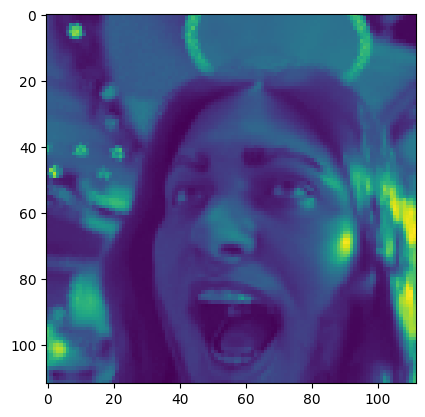

In [36]:
enc.eval()
with torch.no_grad():
    image_a = train_dataset[5][0].to(device)
    image_same = train_dataset[71][0].to(device)
    image_diff = train_dataset[4000][0].to(device)
    
    pdist = torch.nn.PairwiseDistance(p=2)
    emb_1 = enc.encoder(image_a.unsqueeze(1))
    emb_same = enc.encoder(image_same.unsqueeze(1))
    emb_diff = enc.encoder(image_diff.unsqueeze(1))
    print(pdist(emb_1, emb_same))
    print(pdist(emb_1, emb_diff))
    
    plt.imshow(image_diff.cpu().permute(1, 2, 0))    

In [27]:
torch.save(enc.state_dict(), "softmax_sd.pth")

In [162]:
def get_face_tensor(imgfile):
    face_cascade = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_frontalface_default.xml')
    eyes_cascade = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_eye.xml')
    img=cv.imread(imgfile)
    gray=cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1,2)

    cropped_image = gray[faces[0][1]:faces[0][1]+faces[0][3], faces[0][0]:faces[0][0]+faces[0][2]] # Slicing to crop the image
    eyes = eyes_cascade.detectMultiScale(cropped_image)
    cropped_image = cv.resize(cropped_image, (112,112))/255
    if len(eyes) < 2:
        return None
    else:
        return (torch.tensor(cropped_image).float().unsqueeze(0).unsqueeze(0).to(device))

tensor([1.4139e+16], device='cuda:0', grad_fn=<NormBackward1>)
tensor([1.4136e+16], device='cuda:0', grad_fn=<NormBackward1>)
tensor([1.4130e+16], device='cuda:0', grad_fn=<NormBackward1>)


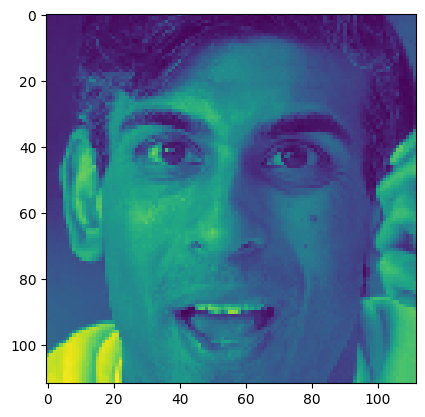

In [179]:
# me1 = get_face_tensor("me1.jpg")
# me2 = get_face_tensor("me2.jpg")
# me3 = get_face_tensor("me3.jpg")
# notme= get_face_tensor("notme4-white.jpg")

person = "rs"

img1 = get_face_tensor(person+ "1.jpg")
img2 = get_face_tensor(person+ "2.jpg")
img3 = get_face_tensor(person+ "3.jpg")

plt.imshow(img1.squeeze(0).permute(1, 2, 0).cpu())
plt.imshow(img2.squeeze(0).permute(1, 2, 0).cpu())
plt.imshow(img3.squeeze(0).permute(1, 2, 0).cpu())


enc.eval()

pdist = torch.nn.PairwiseDistance(p=2)
# emb_me1 = enc(me1)
# emb_me2 = enc(me2)
# emb_me3 = enc(me3)
# emb_me_avg = (emb_me1+emb_me2+emb_me3)/3
# emb_notme = enc.encoder(notme)

emb_img1 = enc(img1)*10e15
emb_img2 = enc(img2)*10e15
emb_img3 = enc(img3)*10e15

print(pdist(emb_img1, emb_img2))
print(pdist(emb_img1, emb_img3))
print(pdist(emb_img2, emb_img3))

# print(pdist(emb_me1, emb_me2))
# print(pdist(emb_me1, emb_me3))
# print(pdist(emb_me2, emb_me3))
# print(pdist(emb_me_avg, emb_notme))

# print(pdist(emb_me2, emb_notme))
# print(pdist(emb_me3, emb_notme))